<a href="https://colab.research.google.com/github/Farhad-Davaripour/Navigating_GenAI/blob/main/function_calling/basic_function_calling_demo.ipynb" target="_parent">
    <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab"/>
</a>

# Invoking an LLM

In [ ]:
%pip install openai, sklearn

In [29]:
from openai import OpenAI
from sklearn.metrics.pairwise import cosine_similarity

OPENAI_API_KEY=""

client = OpenAI(
  api_key=OPENAI_API_KEY
)

In [31]:
# Generate response using the language model
def create_prompt(prompt):
    return [
        {
            "role": "system",
            "content": [
                {
                    "type": "text",
                    "text": "You are an AI assistant that provides answer to the user's query."
                }
            ]
        },
        {
            "role": "user",
            "content": [
                {
                    "type": "text",
                    "text": f"{prompt}"
                }
            ]
        },
    ]

In [46]:
def generate_response(prompt):
    response = client.chat.completions.create(
        model="gpt-4o",  # Replace with the appropriate model name
        messages=create_prompt(prompt),
        max_tokens=150
    )
    return response

def print_response(prompt):
    response = generate_response(prompt)
    for key in response.choices[0]:
        print(key)
    print("\nResponse: ", response.choices[0].message.content)

In [47]:
response = print_response("What is the capital of Canada")

('finish_reason', 'stop')
('index', 0)
('logprobs', None)
('message', ChatCompletionMessage(content='The capital of Canada is Ottawa.', role='assistant', function_call=None, tool_calls=None))

Response:  The capital of Canada is Ottawa.


In [50]:
x_values = [1, 2, 3, 4, 5]
y_values = [10, 20, 25, 30, 35]

response = print_response(f'generate a scatter plot with x values {x_values} and y values {y_values}')

('finish_reason', 'length')
('index', 0)
('logprobs', None)
('message', ChatCompletionMessage(content="Certainly! Here is a simple Python example using Matplotlib to generate a scatter plot with the given x and y values:\n\n```python\nimport matplotlib.pyplot as plt\n\n# Define x and y values\nx_values = [1, 2, 3, 4, 5]\ny_values = [10, 20, 25, 30, 35]\n\n# Create a scatter plot\nplt.scatter(x_values, y_values)\n\n# Add title and labels\nplt.title('Scatter Plot of Given Values')\nplt.xlabel('X Values')\nplt.ylabel('Y Values')\n\n# Show the plot\nplt.show()\n```\n\nTo run this code, make sure you have Matplotlib installed. You can install it using pip if you haven't already", role='assistant', function_call=None, tool_calls=None))

Response:  Certainly! Here is a simple Python example using Matplotlib to generate a scatter plot with the given x and y values:

```python
import matplotlib.pyplot as plt

# Define x and y values
x_values = [1, 2, 3, 4, 5]
y_values = [10, 20, 25, 30, 35]

# 

In [ ]:
%pip install matplotlib, langchain, langchain_core, langchain_openai

# Function Calling

In [51]:
import matplotlib.pyplot as plt
from langchain.agents import tool

@tool
def scatter_plot(x: list, y: list):
    """
    Plot a scatter plot using two lists: x and y
    :param x: List of x values
    :param y: List of y values
    """
    

    if len(x) != len(y):
        raise ValueError("The length of x and y must be the same")

    plt.scatter(x, y)
    plt.xlabel('X values')
    plt.ylabel('Y values')
    plt.title('Scatter Plot of X vs Y')
    plt.grid(True)
    plt.show()


In [52]:
tools = [scatter_plot]

In [53]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are an AI assistant that provides answer to the user's query.",
        ),
        ("user", "{input}"),
        MessagesPlaceholder(variable_name="agent_scratchpad"),
    ]
)

In [54]:
from langchain_openai import ChatOpenAI
from langchain.agents.format_scratchpad.openai_tools import format_to_openai_tool_messages
from langchain.agents.output_parsers.openai_tools import OpenAIToolsAgentOutputParser
from langchain.agents import AgentExecutor

llm = ChatOpenAI(temperature=0.1, model="gpt-4o")
llm_with_tools = llm.bind_tools(tools)

agent = (
    {
        "input": lambda x: x["input"],
        "agent_scratchpad": lambda x: format_to_openai_tool_messages(
            x["intermediate_steps"]
        ),
    }
    | prompt
    | llm_with_tools
    | OpenAIToolsAgentOutputParser()
)

agent_executor = AgentExecutor(
    agent=agent, tools=tools, verbose=False, handle_parsing_errors=True
)

In [55]:
def agent_executor_fn(prompt: str) -> str:
    return list(agent_executor.stream({"input": prompt}))

In [56]:
response = agent_executor_fn('tell me a joke')

for key in response:
    print(key)

{'output': "Why don't scientists trust atoms?\n\nBecause they make up everything!", 'messages': [AIMessage(content="Why don't scientists trust atoms?\n\nBecause they make up everything!")]}


{'actions': [ToolAgentAction(tool='scatter_plot', tool_input={'x': [1, 2, 3, 4, 5], 'y': [10, 20, 25, 30, 35]}, log="\nInvoking: `scatter_plot` with `{'x': [1, 2, 3, 4, 5], 'y': [10, 20, 25, 30, 35]}`\n\n\n", message_log=[AIMessageChunk(content='', additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_pdEFcP8akupYtcUfaIikKJ4p', 'function': {'arguments': '{"x":[1,2,3,4,5],"y":[10,20,25,30,35]}', 'name': 'scatter_plot'}, 'type': 'function'}]}, response_metadata={'finish_reason': 'tool_calls'}, id='run-6c2c9abb-0f2b-4bff-9a41-1f5acc1d5c88', tool_calls=[{'name': 'scatter_plot', 'args': {'x': [1, 2, 3, 4, 5], 'y': [10, 20, 25, 30, 35]}, 'id': 'call_pdEFcP8akupYtcUfaIikKJ4p'}], tool_call_chunks=[{'name': 'scatter_plot', 'args': '{"x":[1,2,3,4,5],"y":[10,20,25,30,35]}', 'id': 'call_pdEFcP8akupYtcUfaIikKJ4p', 'index': 0}])], tool_call_id='call_pdEFcP8akupYtcUfaIikKJ4p')], 'messages': [AIMessageChunk(content='', additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_pdEFcP8akupYtcUfaIi

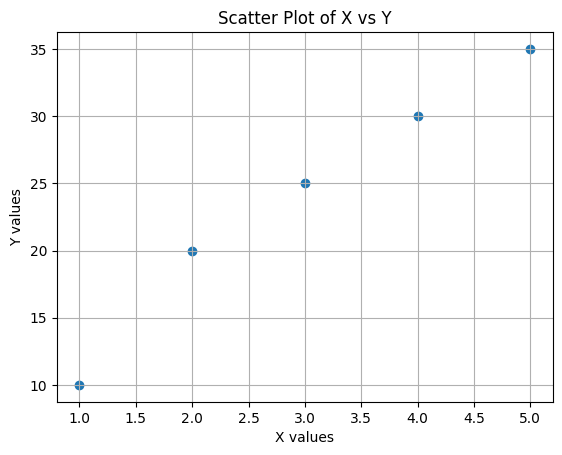

In [58]:
x_values = [1, 2, 3, 4, 5]
y_values = [10, 20, 25, 30, 35]

for key in response:
    print(key)

response = agent_executor_fn(f'plot a scatter plot with x values {x_values} and y values {y_values}')